In [127]:
#https://www.zybuluo.com/hanbingtao/note/485480
#卷积神经网络(Convolutional Neural Network, CNN)

#数据下载
# from tensorflow.examples.tutorials.mnist import input_data
# mnist=input_data.read_data_sets('/tmp/',one_hot=True)
#或者：download:http://yann.lecun.com/exdb/mnist/

#文件路径
import os

base_path='/Users/yexianyong/Downloads/machine_learning/mnist'
training_images_path=os.path.join(base_path,'train-images-idx3-ubyte')
training_labels_path=os.path.join(base_path,'train-labels-idx1-ubyte')
test_images_path=os.path.join(base_path,'t10k-images-idx3-ubyte')
test_labels_path=os.path.join(base_path,'t10k-labels-idx1-ubyte')

training_images_path

'/Users/yexianyong/Downloads/machine_learning/mnist/train-images-idx3-ubyte'

In [128]:
#读取文件
#http://blog.csdn.net/simple_the_best/article/details/75267863
import struct
import numpy as np

def load_mnist(images_path,labels_path,kind='train'):
    """Load MNIST data from path"""
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
images,labels=load_mnist(training_images_path,training_labels_path)
images,labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

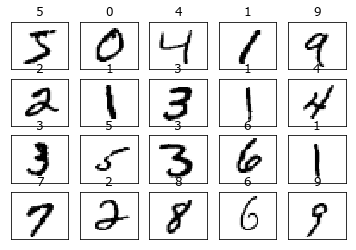

In [129]:
#可视化
import matplotlib.pyplot as plt
fig,ax=plt.subplots(nrows=4,ncols=5,sharex=True,sharey=True)

ax = ax.flatten()
for i in range(20):
    img = images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(labels[i])
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

# 卷积测试

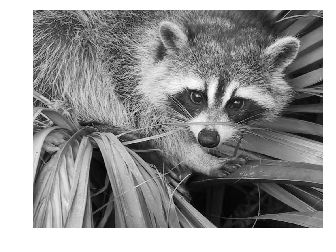

(768, 1024)

In [219]:
def show(img):
    fig,ax=plt.subplots()
    imgplot=plt.imshow(img)
    ax.set_axis_off()
    plt.gray()
    plt.show()


from scipy import signal,misc
img=misc.face(gray=True)
show(img)
img.shape

In [190]:
np.random.seed(1)
filter_=np.random.rand(50,50)
filter_

array([[4.17e-01, 7.20e-01, 1.14e-04, ..., 2.94e-01, 2.88e-01, 1.30e-01],
       [1.94e-02, 6.79e-01, 2.12e-01, ..., 5.74e-01, 2.87e-03, 6.17e-01],
       [3.27e-01, 5.27e-01, 8.86e-01, ..., 7.13e-01, 5.60e-01, 1.26e-02],
       ...,
       [1.47e-01, 6.12e-01, 2.79e-01, ..., 7.05e-03, 5.95e-02, 4.81e-01],
       [9.26e-01, 4.06e-01, 7.50e-02, ..., 1.67e-01, 5.21e-01, 7.40e-01],
       [4.62e-01, 8.70e-01, 6.60e-01, ..., 5.68e-01, 3.43e-01, 3.51e-01]])

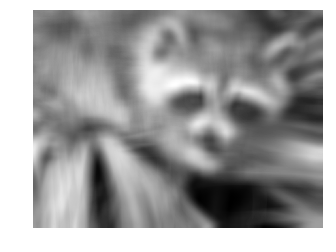

(768, 1024)

In [193]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html
#对于boundary和fillvalue的说明：
#当boundary=‘fill’的时候，fillvalue才会生效,fillvalue默认0

feature=signal.convolve2d(img,filter_,mode='same',boundary='symm')
show(feature)
feature.shape

# 池化测试
### 常见的池化操作有：
---
**平均池化(mean polling):**计算图像区域的平均值作为该区域池化后的值;

**最大池化（max pooling）:**选图像区域的最大值作为该区域池化后的值；

**重叠池化（overlapping pooling）：**相邻池化窗口之间会有重叠区域；

**空间金字塔池化（spatial pyramid pooling）：**空间金字塔池化，使得任意大小的特征图都能够转换成固定大小的特征向量，这就是空间金字塔池化的意义（多尺度特征提取出固定大小的特征向量），送入全连接层。

### 空间金字塔池化如何提取特征，得到固定大小的特征向量？
---
我们假设一个很简单两层网络：输入一张任意大小的图片,假设其大小为(w,h)，输出21个神经元。也就是我们输入一张任意大小的特征图的时候，我们希望提取出21个特征。空间金字塔特征提取的过程如下：
![](http://img.blog.csdn.net/20160511195707981)
如上图所示，当我们输入一张图片的时候，我们利用不同大小的刻度，对一张图片进行了划分。上面示意图中，利用了三种不同大小的刻度（4*4,2*2,1*1），对一张输入的图片进行了划分，最后总共可以得到16+4+1=21个块，我们即将从这21个块中，每个块提取出一个特征，这样刚好就是我们要提取的21维特征向量。
引用自[空间金字塔池化](http://blog.csdn.net/u013110060/article/details/61199597)


In [202]:
np.random.seed(1)
arr=np.random.choice(10,(4,4))
arr

array([[5, 8, 9, 5],
       [0, 0, 1, 7],
       [6, 9, 2, 4],
       [5, 2, 4, 2]])

In [204]:
from skimage import measure
arr_poolinged=measure.block_reduce(arr,(2,2),np.max)
arr_poolinged

array([[8, 9],
       [9, 4]])

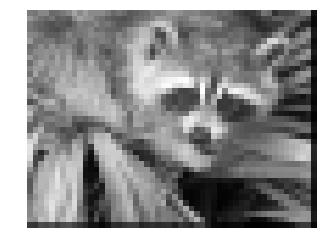

(39, 52)

In [218]:
#平均池化
img_poolinged=measure.block_reduce(img,(20,20),np.mean)
show(img_poolinged)
img_poolinged.shape

# 正式开始

### 超参数如何确定
https://www.zhihu.com/question/38098038
![](https://pic2.zhimg.com/50/fc227744f50887c1a4486acd91486b94_hd.jpg)
总之：卷积核，越小越好，降低参数数量，降低复杂度。

### 步骤
* 卷积
* 非线性(ReLU)
* 池化或下采样
* 分类（全连接层）

In [217]:






for x,y in zip(images,labels):
    print (y)
    
    
    
    
    
    

5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7
2
8
6
9
4
0
9
1
1
2
4
3
2
7
3
8
6
9
0
5
6
0
7
6
1
8
7
9
3
9
8
5
9
3
3
0
7
4
9
8
0
9
4
1
4
4
6
0
4
5
6
1
0
0
1
7
1
6
3
0
2
1
1
7
9
0
2
6
7
8
3
9
0
4
6
7
4
6
8
0
7
8
3
1
5
7
1
7
1
1
6
3
0
2
9
3
1
1
0
4
9
2
0
0
2
0
2
7
1
8
6
4
1
6
3
4
5
9
1
3
3
8
5
4
7
7
4
2
8
5
8
6
7
3
4
6
1
9
9
6
0
3
7
2
8
2
9
4
4
6
4
9
7
0
9
2
9
5
1
5
9
1
2
3
2
3
5
9
1
7
6
2
8
2
2
5
0
7
4
9
7
8
3
2
1
1
8
3
6
1
0
3
1
0
0
1
7
2
7
3
0
4
6
5
2
6
4
7
1
8
9
9
3
0
7
1
0
2
0
3
5
4
6
5
8
6
3
7
5
8
0
9
1
0
3
1
2
2
3
3
6
4
7
5
0
6
2
7
9
8
5
9
2
1
1
4
4
5
6
4
1
2
5
3
9
3
9
0
5
9
6
5
7
4
1
3
4
0
4
8
0
4
3
6
8
7
6
0
9
7
5
7
2
1
1
6
8
9
4
1
5
2
2
9
0
3
9
6
7
2
0
3
5
4
3
6
5
8
9
5
4
7
4
2
7
3
4
8
9
1
9
2
8
7
9
1
8
7
4
1
3
1
1
0
2
3
9
4
9
2
1
6
8
4
7
7
4
4
9
2
5
7
2
4
4
2
1
9
7
2
8
7
6
9
2
2
3
8
1
6
5
1
1
0
2
6
4
5
8
3
1
5
1
9
2
7
4
4
4
8
1
5
8
9
5
6
7
9
9
3
7
0
9
0
6
6
2
3
9
0
7
5
4
8
0
9
4
1
2
8
7
1
2
6
1
0
3
0
1
1
8
2
0
3
9
4
0
5
0
6
1
7
7
8
1
9
2
0
5
1
2
2
7
3
5
4
9
7
1
8
3
9
6
0
3
1
1
2
6
3
5
7
6
8


0
1
9
1
1
7
2
1
5
5
4
6
5
4
7
4
7
8
5
4
3
4
0
2
2
5
2
1
2
6
7
1
3
5
1
5
4
3
4
6
3
7
0
1
0
2
4
9
7
2
9
6
7
2
8
6
8
0
7
0
9
0
6
9
3
4
1
7
7
4
9
2
6
6
3
3
3
3
1
3
0
4
2
7
6
9
0
3
5
1
6
3
6
4
8
7
7
3
3
8
5
9
8
3
3
4
0
7
1
6
2
0
3
8
7
4
8
3
9
2
0
7
3
8
4
0
7
1
8
0
0
5
1
4
2
1
3
7
4
7
5
1
6
5
7
5
8
9
9
8
5
0
1
5
9
6
9
0
7
4
1
9
0
2
9
8
0
7
5
3
9
7
7
7
1
7
3
4
6
7
3
0
2
3
0
0
9
4
0
8
6
9
1
3
7
7
2
0
8
7
3
6
4
9
7
6
6
7
6
9
3
8
2
7
3
0
8
5
9
9
4
2
8
4
8
8
7
4
1
8
0
1
8
6
7
7
7
7
5
2
9
3
2
6
3
6
1
4
1
6
4
4
5
1
5
2
0
5
4
3
8
1
7
7
4
5
9
6
2
2
3
6
6
7
4
8
1
4
2
4
4
8
1
2
5
0
1
2
9
8
3
5
2
7
0
4
0
9
2
7
9
4
3
5
6
4
0
9
1
8
2
1
3
7
4
2
5
2
6
7
7
5
8
8
9
1
0
1
1
0
2
3
3
1
4
4
5
0
6
4
7
0
8
1
9
1
0
3
1
3
2
3
3
3
4
2
5
7
6
2
7
6
8
4
9
1
8
6
0
7
5
7
6
0
6
1
0
6
8
4
0
4
2
2
3
9
7
6
9
7
4
2
7
3
1
1
9
0
1
5
7
6
1
5
0
4
0
1
4
9
1
3
7
6
5
2
7
2
1
8
3
8
3
8
3
3
1
6
6
0
9
5
7
7
4
9
3
5
0
8
2
5
5
1
2
7
6
9
0
0
8
2
9
6
4
5
3
4
5
7
4
6
8
5
1
0
5
4
9
3
0
9
6
3
4
8
6
4
8
3
1
6
4
0
7
1
5
2
7
2
2
2
2
8
0
1
0
0
1
3


2
8
4
0
7
1
2
2
1
3
4
4
1
5
8
6
9
7
4
8
9
9
6
1
9
6
5
8
6
9
9
9
1
0
9
1
8
2
1
4
5
4
3
3
0
7
6
4
3
4
4
4
9
0
8
3
8
8
6
7
0
5
5
1
7
5
8
8
0
9
3
2
5
5
4
1
6
1
9
6
8
2
3
1
3
3
3
8
2
6
7
4
4
9
3
2
0
0
0
0
7
1
7
6
6
2
0
5
6
5
8
0
6
2
2
8
7
0
4
6
2
8
8
1
0
7
7
9
3
1
5
9
3
2
5
6
8
7
5
6
9
6
1
8
2
7
6
4
2
9
2
2
8
1
2
3
6
3
1
0
2
5
1
5
6
7
1
9
2
7
3
0
7
2
3
7
7
9
7
1
3
3
6
6
4
7
2
8
7
0
1
3
9
5
1
3
3
6
0
0
1
1
3
2
3
3
9
6
9
7
9
8
0
9
1
0
8
1
6
2
2
3
5
4
0
5
3
6
5
7
5
0
5
1
1
2
8
3
5
4
6
5
5
6
0
7
5
8
9
9
4
8
1
7
5
4
1
3
7
9
8
8
2
8
4
3
8
1
5
5
5
8
4
2
9
7
2
4
5
2
1
6
3
5
7
2
5
4
3
5
4
6
9
4
4
1
9
7
2
5
2
1
3
3
0
3
1
6
0
9
8
6
4
3
3
3
5
1
7
6
3
5
3
6
0
1
3
9
7
3
9
7
1
4
7
7
7
0
4
9
6
0
0
0
4
3
7
7
6
9
9
2
5
0
0
1
7
0
0
1
0
0
6
4
5
0
5
4
3
7
6
9
7
2
2
0
1
6
0
2
0
2
1
9
3
9
2
0
6
1
2
2
8
3
1
4
7
5
4
6
7
7
6
8
7
9
9
0
0
1
2
2
7
3
6
4
5
5
3
6
2
7
3
8
7
0
0
1
6
2
8
3
0
5
9
6
6
7
4
8
7
5
1
4
2
8
0
7
2
4
7
7
1
7
0
3
8
9
6
8
4
8
7
3
1
1
8
5
4
8
5
2
1
7
2
4
6
2
6
6
5
1
6
5
7
2
1
4
4
5
7
5
1
8
3
6
8
4
6
4


5
2
8
5
9
7
0
8
8
9
1
8
4
0
8
1
7
2
2
3
3
4
3
5
3
6
7
7
0
8
4
9
1
0
2
1
9
2
6
3
7
4
5
5
2
6
0
7
5
8
1
9
9
0
1
1
8
2
4
3
4
4
8
5
1
6
6
7
5
8
7
9
5
1
3
2
9
6
2
5
4
3
7
0
5
2
0
8
7
7
5
0
1
3
5
6
0
4
7
4
5
3
2
6
0
7
2
2
7
3
9
9
2
1
9
2
5
1
2
2
1
9
8
6
2
0
2
1
4
3
6
0
7
2
8
7
9
5
5
7
9
6
0
1
5
9
7
0
1
6
4
0
0
6
0
0
8
2
9
0
3
6
5
1
8
5
6
8
2
4
4
3
6
0
5
1
9
5
3
4
6
4
4
8
6
8
8
4
4
5
1
7
4
5
3
7
0
8
5
3
4
4
9
8
3
8
1
5
5
2
9
9
5
7
4
1
9
3
1
8
8
1
1
0
2
7
6
5
1
9
3
6
7
9
9
4
7
7
2
7
7
9
6
9
8
5
1
8
9
3
6
4
0
4
4
3
3
8
2
6
3
2
1
0
8
1
4
2
4
3
0
7
0
8
7
9
0
3
7
4
3
7
7
9
4
0
6
1
9
2
4
3
1
7
6
8
2
3
8
8
9
7
6
1
1
0
1
7
1
6
5
9
5
0
3
1
8
0
9
0
4
1
6
0
6
9
9
3
0
4
9
7
8
6
2
9
2
2
6
1
1
6
7
4
3
4
3
1
1
2
0
2
9
1
7
3
8
2
9
9
1
3
5
2
5
1
6
2
6
1
5
6
2
7
8
2
8
3
0
8
7
7
3
5
4
7
2
0
3
7
8
4
7
6
6
3
0
7
5
6
8
9
1
9
3
4
0
8
1
4
6
1
6
0
3
6
2
6
4
0
4
1
5
2
0
3
4
4
9
5
9
6
8
7
4
8
9
9
5
0
2
3
7
4
3
5
8
6
3
7
3
8
2
9
7
0
1
1
1
2
1
3
2
4
7
5
0
6
8
7
3
8
8
9
8
0
4
5
2
5
5
6
3
5
2
0
6
9
8
8
4
9
1
8
6
4
9
1
9
7


3
7
7
9
9
7
1
0
1
1
8
2
2
3
3
4
1
5
3
6
6
7
8
8
2
9
5
0
2
1
5
2
7
3
9
4
6
5
1
6
1
7
0
8
3
9
8
0
1
1
3
2
2
3
1
4
5
7
7
8
3
9
3
2
7
2
7
7
9
6
5
4
7
7
3
3
9
5
1
4
0
1
7
8
0
0
6
5
3
2
9
7
7
2
4
3
6
6
2
2
1
1
4
7
8
7
0
9
9
9
3
1
2
2
4
4
0
6
1
7
8
7
9
5
7
4
0
5
1
0
5
9
8
9
1
8
4
0
8
2
0
0
7
3
0
5
4
1
2
8
8
6
6
4
1
6
6
0
7
6
1
4
0
3
9
9
1
3
3
0
2
0
3
5
0
2
9
5
2
8
5
8
5
9
0
4
5
3
1
4
1
2
9
8
2
5
3
5
7
7
8
1
4
3
6
6
1
9
3
4
7
1
3
3
7
8
5
7
0
6
2
9
3
3
9
3
2
7
1
4
6
1
9
9
3
1
4
0
4
0
3
1
8
2
9
3
2
4
8
5
6
7
0
8
0
9
0
0
1
1
0
2
3
3
3
4
1
5
5
6
5
7
9
8
4
0
2
1
9
2
4
4
4
5
1
6
0
7
6
8
9
8
4
9
8
9
6
0
7
1
8
2
7
4
5
7
1
4
0
0
6
3
4
8
6
8
1
2
1
1
0
7
0
3
4
5
5
8
0
5
0
5
2
9
7
2
4
5
1
1
3
1
1
6
1
2
9
1
1
3
1
8
0
6
5
4
5
9
3
4
4
9
3
2
3
0
6
0
9
4
1
4
8
6
9
0
8
2
5
8
2
0
6
6
1
8
4
1
9
7
6
9
9
1
9
9
8
2
1
6
2
7
2
6
0
6
1
8
5
4
5
9
7
2
0
1
1
3
5
0
7
5
5
5
1
8
9
0
0
3
8
7
7
9
5
7
1
0
9
2
4
7
8
3
6
6
4
7
3
8
4
0
8
3
6
5
6
0
2
1
9
2
8
3
0
4
6
5
9
7
3
8
8
0
7
1
6
2
3
3
2
4
3
7
5
8
3
9
0
0
8
1
9
2
3
3
2
4
3
7


4
6
0
8
7
1
8
0
7
4
7
2
9
1
0
1
4
0
9
4
9
5
7
6
4
9
2
6
0
6
5
5
8
5
5
3
9
4
8
9
8
5
4
2
0
4
7
6
1
4
3
8
5
2
6
6
5
1
3
4
8
1
7
0
3
4
1
7
6
5
8
4
5
3
9
8
2
5
2
7
0
8
9
9
2
7
4
7
6
6
5
5
2
4
1
6
3
4
6
7
6
3
2
8
1
7
2
6
6
7
0
9
7
3
4
4
7
2
8
2
9
6
2
5
9
3
5
7
1
0
8
3
3
9
5
5
6
5
8
9
0
1
0
6
9
9
9
5
3
9
1
8
1
7
0
0
1
1
2
6
3
7
4
1
5
2
6
6
7
8
8
2
9
9
0
6
1
2
2
3
3
6
4
7
5
7
6
0
7
1
8
6
9
5
0
2
1
3
2
7
3
2
4
7
7
8
8
5
9
5
0
3
7
3
0
2
7
9
8
1
3
3
0
1
0
5
5
2
5
0
3
6
8
5
8
4
1
5
4
9
6
7
1
0
8
1
0
2
2
8
7
6
3
1
9
1
4
0
1
5
2
3
5
1
9
9
8
3
9
9
5
5
4
1
3
5
0
9
3
4
3
9
4
0
7
0
1
1
2
3
1
8
0
1
6
2
2
4
3
6
8
6
9
7
5
4
6
5
6
1
7
1
1
5
4
0
6
2
2
5
9
5
1
6
5
6
5
0
5
5
3
8
1
7
4
2
8
4
6
5
3
0
7
2
0
9
9
7
5
8
6
9
7
2
1
1
3
4
2
6
6
1
2
3
6
8
7
8
8
7
7
1
0
5
1
4
2
9
3
7
4
0
5
2
6
1
7
3
8
0
9
9
0
4
1
2
2
5
3
9
4
8
5
8
6
5
7
9
8
7
9
2
0
2
1
2
2
6
3
4
4
1
5
7
6
0
7
8
8
3
9
6
6
4
4
0
2
2
6
1
4
7
7
3
5
7
5
8
4
8
7
2
8
4
9
9
2
5
9
6
3
2
9
9
3
7
8
3
2
5
0
1
9
0
8
6
0
4
5
0
6
1
0
9
1
4
0
1
4
7
2
1
6
9
5
7
3
2
5
2


0
5
4
7
6
6
6
4
9
9
4
1
2
9
8
1
2
4
5
1
1
1
0
0
5
6
0
7
3
0
4
1
3
2
9
9
6
5
7
7
3
7
4
0
3
4
0
2
6
4
9
1
0
3
1
1
2
8
3
7
4
2
5
6
6
8
7
4
8
5
9
6
0
6
1
2
2
2
3
7
4
0
5
6
6
4
0
1
1
9
2
6
3
5
4
3
5
9
6
5
7
7
8
8
9
1
2
0
1
8
2
4
1
9
3
9
9
1
9
8
3
2
7
0
0
3
7
8
7
1
5
2
7
2
9
2
9
6
4
2
7
7
0
6
1
3
4
8
4
2
7
0
5
1
8
2
1
7
4
1
9
9
8
0
4
1
1
1
8
4
6
1
6
3
4
5
6
3
0
5
5
9
5
9
3
3
3
2
5
2
2
7
5
0
7
0
2
3
5
2
9
5
6
2
9
2
2
0
6
9
2
4
1
1
2
2
0
0
8
7
3
1
8
6
3
4
0
8
8
9
7
4
4
4
9
7
5
3
0
1
9
6
7
1
0
2
0
6
4
0
9
9
1
5
6
1
2
2
7
8
6
5
8
8
3
3
5
9
2
8
1
1
8
8
6
9
1
5
0
0
3
5
1
7
4
8
0
2
1
9
2
2
3
5
4
3
5
5
6
1
7
3
8
6
9
5
0
6
1
2
2
8
3
3
4
1
5
9
6
4
7
6
8
0
0
2
1
3
2
0
3
5
1
0
5
0
6
9
7
3
8
1
7
9
0
9
6
4
0
0
7
5
3
8
8
5
6
2
7
6
1
6
3
4
7
3
9
9
7
9
4
7
0
0
2
2
5
0
0
3
6
9
4
4
9
4
5
0
6
4
5
8
2
3
9
8
8
3
5
5
1
8
9
1
8
1
3
0
4
1
0
8
5
4
4
2
8
6
6
8
3
4
4
2
8
5
0
8
6
6
4
0
8
5
1
7
3
1
4
4
0
7
1
1
9
1
2
8
3
3
7
9
1
7
2
5
7
3
2
9
8
0
7
7
0
2
1
0
9
6
6
7
4
6
9
6
2
4
1
7
2
2
3
7
7
9
0
2
2
1
1
5
3
6
4
9
7
6
2
4


3
9
1
4
1
3
5
7
9
2
4
3
3
3
0
2
4
8
0
7
9
2
6
7
9
3
2
6
2
2
1
1
7
4
9
3
5
1
1
4
1
2
9
8
8
0
6
8
9
4
0
7
0
1
0
6
1
4
8
8
4
7
8
1
8
1
2
3
6
8
3
8
2
1
9
3
2
1
4
5
0
3
9
5
0
0
3
1
7
4
4
6
5
8
8
9
3
5
5
2
8
2
5
4
4
0
7
8
6
4
5
0
2
6
2
4
2
0
7
1
7
1
0
9
5
1
1
1
5
7
3
1
0
7
1
8
2
6
5
5
6
0
7
9
8
1
9
4
0
4
1
4
2
1
3
0
4
5
5
0
6
5
7
6
8
0
0
6
1
4
2
7
3
5
4
7
5
3
6
3
7
2
8
6
9
9
2
8
1
5
7
5
2
4
5
7
0
2
8
7
0
3
2
1
7
5
8
5
8
9
3
7
0
8
6
6
0
7
2
4
7
2
6
1
6
2
1
8
2
8
8
2
8
3
7
3
7
5
4
9
7
2
7
3
3
2
7
3
4
6
5
1
4
7
3
3
3
0
8
9
4
6
5
9
4
5
1
9
1
2
9
3
7
0
4
5
3
5
7
3
3
0
3
6
0
6
2
6
5
5
5
7
6
5
3
1
1
9
5
0
2
1
5
8
9
9
9
7
8
1
4
5
1
8
0
5
6
2
0
7
9
3
6
9
8
6
8
6
5
7
6
7
1
8
1
2
9
0
8
5
9
5
2
6
3
6
5
1
5
5
9
8
4
4
2
3
1
8
9
2
4
8
9
4
1
8
3
4
9
0
2
2
0
6
6
8
0
3
4
5
0
3
6
2
0
3
1
8
2
4
3
0
4
4
6
3
8
8
1
1
2
0
3
7
4
1
5
9
6
2
7
7
9
5
1
1
2
6
3
5
4
4
5
4
6
0
7
2
8
4
6
5
6
1
0
7
2
0
3
9
7
3
4
1
7
2
1
2
9
0
1
9
7
4
1
8
4
6
0
6
0
5
1
2
7
8
5
6
7
9
1
0
3
9
3
8
3
1
1
7
6
1
9
1
7
6
4
7
3
9
0
3
2
5
6
9
0
7
8
9


8
7
9
8
1
9
4
0
5
9
1
5
3
5
2
6
8
9
3
8
9
9
4
8
8
7
3
7
3
3
9
5
1
1
6
0
6
2
4
2
7
7
5
8
9
2
8
0
1
1
4
2
0
6
5
3
9
3
5
7
3
3
7
3
8
4
2
6
3
6
4
6
8
1
5
5
1
0
8
8
3
2
3
0
1
1
0
7
6
6
1
3
8
2
1
1
8
7
3
3
9
1
6
3
2
9
7
1
2
7
5
6
6
8
0
4
6
3
0
1
5
4
6
3
6
6
1
9
2
6
6
1
6
4
8
2
9
2
3
7
6
9
4
5
3
4
0
8
6
8
6
4
2
9
3
0
4
8
4
9
3
8
9
0
5
3
4
4
2
5
5
6
8
7
3
8
6
9
3
1
1
0
7
1
1
2
6
3
4
4
2
7
7
8
5
9
4
0
3
1
9
2
5
3
6
4
8
5
3
6
8
7
9
8
2
9
2
0
8
8
9
7
4
8
1
9
3
9
6
0
6
1
9
4
6
5
8
1
8
6
6
2
7
9
6
6
9
7
1
3
6
9
5
9
2
3
3
8
5
1
4
2
3
9
6
6
4
3
3
5
9
0
1
5
5
4
0
3
1
4
2
7
4
7
6
9
4
1
7
4
8
3
8
7
9
6
7
2
3
1
8
5
0
5
4
0
2
5
5
0
2
8
2
4
7
6
3
7
9
0
2
2
8
4
9
8
0
1
8
2
8
2
5
3
2
1
6
3
8
6
2
4
5
9
4
6
0
5
3
1
8
9
8
8
8
1
2
1
3
5
9
0
3
2
3
7
5
8
9
6
6
6
3
8
7
2
1
8
2
4
2
4
8
2
4
2
4
8
7
0
4
0
9
1
7
2
6
3
2
4
0
5
7
6
0
0
8
1
2
2
4
3
1
4
9
5
8
6
3
7
2
8
4
0
4
1
2
2
9
6
7
7
9
8
3
9
6
0
6
2
4
1
5
6
7
5
5
9
0
3
7
5
5
0
2
7
4
1
1
1
3
5
2
3
2
0
3
7
5
9
6
6
3
1
2
6
5
7
5
4
9
9
2
5
5
7
5
9
4
8
7
5
1
6
8
2
7
4
3
8


6
7
8
9
8
4
2
4
3
4
6
9
1
2
2
2
9
5
8
8
9
1
5
9
2
7
5
5
2
0
6
1
2
2
4
4
8
1
4
5
6
2
5
5
1
6
2
0
3
9
4
4
8
1
0
6
1
7
2
7
3
9
4
0
5
9
6
0
7
8
8
2
9
7
0
6
1
5
2
0
3
9
4
7
5
1
6
4
8
8
9
6
5
8
0
5
3
5
1
2
6
6
8
3
4
9
1
0
7
1
6
1
5
8
6
7
4
1
2
5
7
7
8
7
3
6
4
1
3
1
4
9
7
5
2
7
5
3
0
3
1
5
9
9
2
1
3
8
2
0
3
0
5
0
5
6
7
6
8
2
4
0
9
9
9
1
7
1
1
4
9
7
8
7
3
8
4
2
8
2
6
3
3
8
8
5
6
9
0
4
1
1
0
0
6
6
2
9
3
1
8
2
9
6
0
9
7
1
2
8
3
1
4
3
5
1
5
9
2
7
8
9
5
1
4
5
6
2
6
9
6
3
7
7
9
6
1
2
8
3
2
4
1
2
2
8
6
9
5
7
3
1
4
7
7
9
9
0
4
5
5
5
9
6
0
5
1
2
2
9
3
9
4
2
5
6
6
5
7
4
8
8
9
1
0
8
1
7
2
1
3
1
4
3
5
5
6
7
7
7
8
2
9
2
0
6
1
1
2
5
3
7
4
0
5
0
6
0
7
0
8
4
8
1
7
4
7
2
0
8
1
5
3
9
7
1
5
0
2
0
8
3
0
4
7
9
5
9
9
1
9
7
6
7
0
7
9
5
4
2
1
8
1
0
5
5
8
8
5
0
8
1
6
9
3
7
2
7
1
0
2
4
3
3
8
5
3
8
2
4
6
2
5
8
6
1
8
2
2
6
7
9
4
5
8
6
1
1
0
8
5
8
3
2
9
4
4
8
1
6
9
1
2
9
1
0
9
7
6
8
7
2
9
9
6
6
1
0
7
2
3
8
8
9
7
1
2
4
9
0
6
2
5
7
8
4
7
0
5
2
3
5
9
3
0
5
5
5
7
0
1
4
6
1
1
4
0
7
9
4
3
0
3
8
4
7
4
7
0
7
6
1
4
6
2
7
3
2
4
3


8
1
8
5
0
0
8
5
9
2
6
8
4
0
2
4
3
9
4
8
4
3
0
1
5
8
8
2
2
9
5
9
6
5
1
4
7
8
6
2
2
5
8
7
1
1
9
4
8
3
0
9
9
7
4
1
5
2
2
6
9
0
8
7
5
0
3
1
2
2
8
3
5
6
9
7
0
8
8
1
8
2
0
3
1
4
7
7
6
8
2
9
0
0
7
1
7
2
0
3
0
4
8
5
9
6
7
7
7
8
7
9
0
1
8
2
0
6
3
5
1
3
9
0
4
2
1
8
0
7
5
0
7
3
5
6
4
4
8
1
6
4
1
3
8
6
6
7
1
2
1
3
2
9
2
1
2
2
7
1
1
2
1
9
2
6
4
0
7
1
9
3
2
0
7
2
5
5
4
7
2
2
5
9
2
1
6
9
7
0
9
6
7
0
1
6
2
0
1
2
8
0
4
6
5
1
3
5
4
8
5
4
7
3
6
0
2
1
9
4
0
8
5
8
8
4
6
5
2
7
8
5
2
7
4
8
1
3
8
4
5
8
0
8
4
5
5
2
8
9
0
7
4
1
8
3
4
8
9
1
4
0
4
7
1
5
1
9
2
6
0
9
0
4
5
7
1
7
3
9
2
9
3
5
6
8
1
3
7
4
7
4
5
3
4
2
0
0
0
1
7
2
6
3
2
4
3
5
1
6
1
7
0
8
1
0
9
1
8
2
1
3
0
4
9
7
1
8
7
9
6
0
0
1
2
2
4
3
5
4
5
6
7
7
6
0
8
8
0
7
3
8
3
9
5
1
6
4
6
5
1
1
6
6
8
7
1
3
1
2
5
9
1
0
2
5
6
6
0
7
6
3
9
9
6
9
2
3
8
8
7
1
0
2
5
3
0
5
6
0
6
5
0
4
8
0
0
3
0
4
8
7
6
7
0
9
1
4
6
3
5
7
3
6
8
2
4
1
1
5
7
8
8
4
2
6
3
7
8
0
3
2
1
9
4
3
3
4
2
4
6
8
5
1
5
2
2
2
4
3
2
1
7
7
8
3
9
4
1
5
7
1
8
9
8
8
8
1
0
1
5
0
9
2
4
7
7
6
6
8
6
2
4
8
7
4
7
4
0
2


8
3
5
4
5
5
7
6
7
7
4
8
7
9
8
0
0
1
4
2
2
3
6
4
5
5
1
6
8
7
8
8
1
0
2
7
5
5
1
0
3
8
0
4
4
1
3
8
2
8
1
1
4
3
8
1
8
8
1
3
9
7
6
9
7
3
7
0
3
9
6
4
2
4
6
0
4
7
5
4
9
2
1
8
3
7
1
2
9
4
3
7
9
8
4
9
3
3
8
1
5
4
1
6
8
5
9
2
7
2
0
2
4
5
8
6
4
7
8
8
3
7
5
5
7
1
2
6
0
4
0
9
9
2
7
9
2
3
7
5
5
3
0
6
5
6
7
0
3
0
6
2
1
5
6
6
2
4
7
9
7
2
8
7
3
4
2
9
9
5
1
0
3
2
4
2
5
3
0
6
9
1
1
8
9
3
0
8
3
0
5
3
1
5
8
0
1
0
0
6
8
1
7
6
6
9
1
5
1
3
9
9
6
4
0
5
6
8
2
6
8
7
8
1
4
1
6
7
1
0
8
1
1
2
1
3
5
4
1
7
8
8
7
9
9
0
3
1
3
2
6
3
6
4
3
0
5
1
5
2
7
3
4
7
0
8
3
9
2
1
1
5
5
9
7
6
0
9
4
3
0
5
2
0
3
0
1
7
9
9
4
6
2
1
2
6
7
7
9
7
6
9
2
2
0
4
6
8
4
8
3
0
7
6
3
4
7
1
3
2
5
8
5
7
1
1
7
1
7
0
9
7
0
6
9
0
2
1
2
2
5
3
5
4
6
5
7
6
6
7
4
8
0
9
0
1
6
2
2
3
5
4
6
5
9
6
7
7
8
8
1
0
4
1
2
2
0
3
0
4
9
5
9
6
1
7
9
8
0
9
3
8
2
4
1
0
4
0
1
7
8
2
3
6
1
5
7
5
9
3
4
7
1
6
5
6
5
4
1
3
9
2
3
6
4
6
0
4
1
4
8
3
6
8
5
8
9
3
0
0
8
1
8
4
0
5
8
6
3
4
3
7
7
8
9
0
8
3
4
1
5
9
0
0
5
9
2
1
0
2
0
7
7
0
9
1
5
3
9
8
7
2
5
9
1
2
0
7
6
7
9
9
1
4
4
2
4
5
4
8


3
9
8
3
0
0
9
8
6
5
2
6
1
9
0
8
1
7
0
7
6
4
2
1
3
4
8
4
9
7
0
7
7
3
2
1
3
5
4
1
5
0
5
2
2
5
8
1
5
7
4
8
6
0
6
4
6
6
7
7
9
2
1
9
8
0
2
1
1
9
2
6
6
7
5
1
3
4
4
4
7
9
9
0
4
6
0
9
0
8
5
5
9
1
0
8
1
6
2
5
3
7
4
0
5
9
6
1
7
3
8
5
9
1
0
6
1
3
2
4
3
9
4
1
5
6
6
5
7
1
8
2
9
3
0
7
1
4
2
9
3
2
4
1
5
0
6
1
7
4
8
1
9
9
0
3
0
0
1
7
0
5
1
4
2
5
7
9
5
6
3
9
4
7
2
6
4
7
4
9
0
4
0
5
6
7
9
4
6
1
6
5
5
7
7
7
3
4
2
3
2
7
3
2
4
4
4
7
9
6
1
7
4
1
0
1
7
5
9
6
7
8
5
7
6
7
2
2
3
7
1
5
4
6
4
4
0
8
9
5
9
6
6
2
1
8
8
0
3
1
3
8
7
8
3
2
9
6
8
7
8
1
9
9
6
4
8
7
8
5
8
7
4
8
7
9
7
5
6
7
2
1
1
6
9
9
8
0
7
1
8
1
8
0
7
6
2
6
2
7
3
2
9
7
3
2
3
5
0
9
7
7
9
3
5
6
6
5
5
0
0
0
6
9
1
4
5
9
0
0
4
8
1
0
1
8
2
4
8
1
2
5
6
6
1
3
5
0
0
4
1
6
2
3
3
8
4
8
5
1
6
5
7
0
8
1
9
6
0
5
1
7
2
3
3
9
4
2
5
0
8
4
0
3
1
9
2
9
3
6
4
6
5
1
6
3
7
9
8
0
8
1
6
9
5
4
0
5
6
8
8
7
9
0
4
6
1
8
9
3
0
8
4
7
8
1
9
7
1
9
4
9
0
8
5
3
1
1
4
8
0
8
7
0
6
7
0
0
1
8
7
9
0
7
6
4
8
7
9
8
5
4
7
8
9
2
8
5
6
8
0
0
8
1
1
2
7
7
7
9
1
4
3
2
2
5
3
8
1
7
4
2
2
4
0
8
0
8
7
0
